In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import candel
from candel import SPEED_OF_LIGHT

from utils import *

from scipy.stats import norm
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path)

2025-06-13 12:49:01 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-13 12:49:01 indices of zero width: [44]
2025-06-13 12:49:01 found zero-width prior at index 44. Setting it to 0.


In [19]:
root = "/Users/rstiskalek/Projects/CANDEL/results/SH0ES"

mu_host_r2 = read_samples(root, "Cepheid_distances_no_redshift.hdf5", "mu_host")
mu_host_unif = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5", "mu_host")


mu_host_r2_mean = np.mean(mu_host_r2, axis=0)
mu_host_unif_mean = np.mean(mu_host_unif, axis=0)

mu_host_r2_err = np.std(mu_host_r2, axis=0)
mu_host_unif_err = np.std(mu_host_unif, axis=0)

# cz = np.hstack([data["czcmb_cepheid_host"], [667, 327, -582]])
cz = data["czcmb_cepheid_host"]
cz_err = np.ones_like(cz) * 270


In [ ]:
from candel import Redshift2Distmod
from jax import random

from numpyro import sample, plate
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_sample

redshift2distmod = Redshift2Distmod()

mu_mean = np.mean(mu_host_r2, axis=0)
mu_cov = np.cov(mu_host_r2, rowvar=False)

cz = data["czcmb_cepheid_host"]
z = data["czcmb_cepheid_host"] / SPEED_OF_LIGHT
# cz_err = np.ones_like(z) * 450

n_host = len(z)

def model():
    H0 = sample("H0", dist.Uniform(10, 100))

    zmean = sample("zmean", dist.Uniform(0.001, 0.05))
    zstd = sample("zstd", dist.Uniform(0.0001, 0.1))

    # sigma_v = sample("sigma_v", dist.Uniform(0.1, 1000))

    sigma_v = 264

    cz_err = sigma_v
    
    with plate("host", n_host):
        # z_true = sample("z_true", dist.Uniform(0.00001, 0.05))
        z_true = sample("z_true", dist.TruncatedNormal(zmean, zstd, low=0))

        sample("ll_cz", dist.Normal(z_true * SPEED_OF_LIGHT, cz_err), obs=cz)
    # z_true = z

    mu_pred = redshift2distmod(z_true, h=H0 / 100)

    sample("mu_host", dist.MultivariateNormal(mu_pred, mu_cov), obs=mu_mean)

In [106]:
kernel = NUTS(model, init_strategy=init_to_sample())

# Set up and run MCMC
mcmc = MCMC(kernel, num_warmup=500, num_samples=5000, num_chains=1)
mcmc.run(random.PRNGKey(0),)

mcmc.print_summary()
samples = mcmc.get_samples()

__ = samples.pop("z_true")

sample: 100%|██████████| 5500/5500 [00:01<00:00, 2837.75it/s, 15 steps of size 3.82e-01. acc. prob=0.90]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        H0     68.61      1.75     68.57     65.67     71.35    443.01      1.00
 z_true[0]      0.00      0.00      0.00      0.00      0.00    566.59      1.00
 z_true[1]      0.01      0.00      0.01      0.01      0.01   2875.89      1.00
 z_true[2]      0.01      0.00      0.01      0.01      0.01   2268.26      1.00
 z_true[3]      0.01      0.00      0.01      0.01      0.01   1351.96      1.00
 z_true[4]      0.02      0.00      0.02      0.02      0.02   5090.24      1.00
 z_true[5]      0.01      0.00      0.01      0.01      0.01    856.44      1.00
 z_true[6]      0.00      0.00      0.00      0.00      0.00    777.01      1.00
 z_true[7]      0.00      0.00      0.00      0.00      0.00    503.11      1.00
 z_true[8]      0.00      0.00      0.00      0.00      0.00    877.39      1.00
 z_true[9]      0.00      0.00      0.00      0.00      0.00    861.57      1.00
z_true[10]      0.01      0

2025-06-13 13:20:03 saving a corner plot to /Users/rstiskalek/Downloads/MNR_hubble_diagram


/Users/rstiskalek/Projects/candel/candel/util.py:383: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


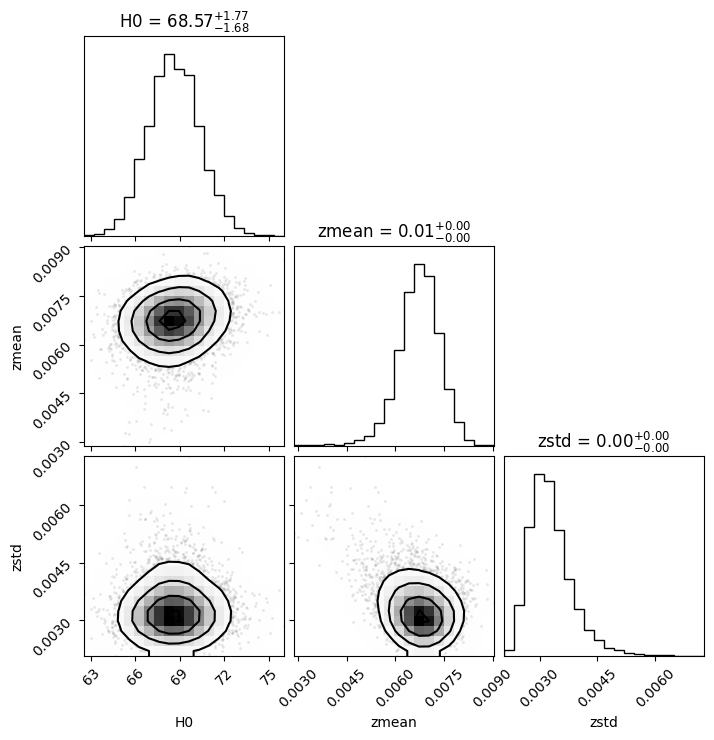

In [107]:
candel.plot_corner(samples, filename="/Users/rstiskalek/Downloads/MNR_hubble_diagram")

In [31]:
from astropy.cosmology import FlatLambdaCDM



czrange = np.linspace(400, 5100, 1000)
zrange = czrange / SPEED_OF_LIGHT

cosmo_SH0ES = FlatLambdaCDM(H0=73.04, Om0=0.3)
mu_SH0ES = cosmo_SH0ES.distmod(czrange / SPEED_OF_LIGHT).value

cosmo_Planck = FlatLambdaCDM(H0=63, Om0=0.3)
mu_Planck = cosmo_Planck.distmod(czrange / SPEED_OF_LIGHT).value

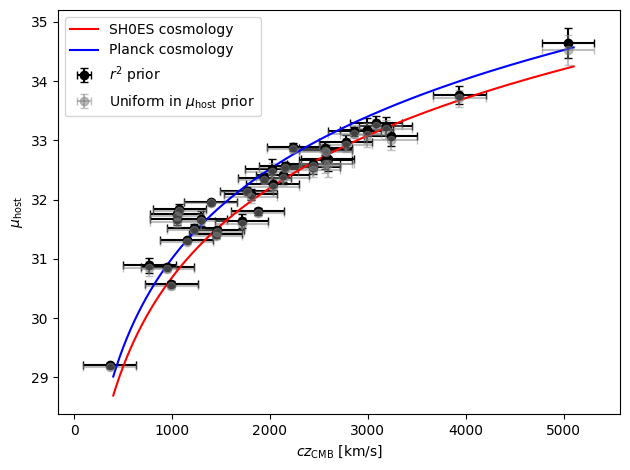

In [32]:
plt.figure()
# plt.title(r"$r^2$ prior on Cepheid host galaxies")
# plt.title(r"Uniform in $mu_{\rm host}$ prior on Cepheid host galaxies")
plt.errorbar(cz, mu_host_r2_mean, xerr=cz_err, yerr=mu_host_r2_err, fmt="o", color="black", label=r"$r^2$ prior", capsize=3)
plt.errorbar(cz, mu_host_unif_mean, xerr=cz_err, yerr=mu_host_unif_err, fmt="o", color="gray", label=r"Uniform in $\mu_{\rm host}$ prior", alpha=0.5, capsize=3)

plt.plot(czrange, mu_SH0ES, color="red", label="SH0ES cosmology")
plt.plot(czrange, mu_Planck, color="blue", label="Planck cosmology")

plt.xlabel(r"$c z_{\rm CMB} ~ [\mathrm{km} / \mathrm{s}]$")
plt.ylabel(r"$\mu_{\rm host}$")

plt.legend()
plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/mu_host_cz.png", dpi=300, bbox_inches="tight")

plt.show()
